In [1]:
import numpyro
import jax
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import seaborn as sns
import arviz as az

numpyro.set_host_device_count(4)
sns.set()

In [2]:
golf_data = """distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24"""

In [3]:
df = pd.read_csv(io.StringIO(golf_data), sep=' ')
feet_to_metres = 0.3048
df['distance'] = (df['distance']*feet_to_metres).round(1)
df['success_rate'] = df['successes']/df['tries']

In [4]:
df

,distance,tries,successes,success_rate
0,0.6,1443,1346,0.932779
1,0.9,694,577,0.831412
2,1.2,455,337,0.740659
3,1.5,353,208,0.589235
4,1.8,272,149,0.547794
5,2.1,256,136,0.531250
6,2.4,240,111,0.462500
7,2.7,217,69,0.317972
8,3.0,200,67,0.335000
9,3.4,237,75,0.316456


## Visualise the data

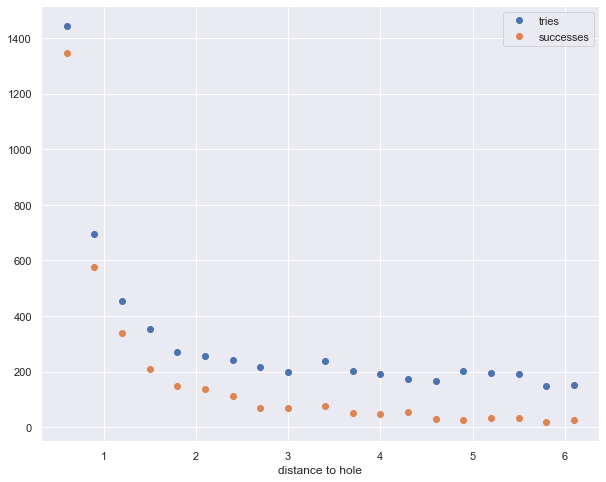

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df['distance'], df['tries'], 'o', label='tries')
ax.plot(df['distance'], df['successes'], 'o', label='successes');
ax.set_xlabel('distance to hole')
ax.legend();

## Cool. Let's "obvious" approach: logistic regression?

In [6]:
def model(distance, tries, successes=None):
    α = numpyro.sample(
        'α',
        numpyro.distributions.Normal(0, 100),
    )
    β = numpyro.sample(
        'β',
        numpyro.distributions.Normal(0, 100),
    )
    logit_probs = α + β*distance
    
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(logit_probs)
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(tries, probs),
        obs=successes,
    )

## Before we begin: sample from the prior

In [7]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    distance=df['distance'].to_numpy(),
    tries=df['tries'].to_numpy(),
)

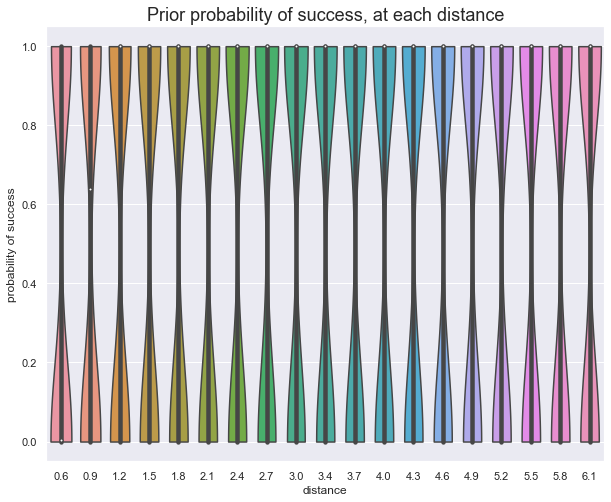

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
prior_probs = pd.DataFrame(prior_samples['probs'])
prior_probs = pd.melt(prior_probs, var_name='distance', value_name='probability of success')
prior_probs['distance'] = prior_probs['distance'].map(df['distance'])
prior_probs
sns.violinplot(data=prior_probs, x='distance', y='probability of success', ax=ax, cut=0);
ax.set_title('Prior probability of success, at each distance', fontdict={'fontsize': 18});

## Hmmm...looks extremely skewed to either 0 or to 1

Let's try with...tighter priors?

In [9]:
def model(distance, tries, successes=None):
    α = numpyro.sample(
        'α',
        numpyro.distributions.Normal(0., 1.5),
    )
    β = numpyro.sample(
        'β',
        numpyro.distributions.Normal(0, .1)
    )
    logit_probs = α + β*distance
    
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(logit_probs)
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(tries, probs),
        obs=successes,
    )

In [10]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    distance=df['distance'].to_numpy(),
    tries=df['tries'].to_numpy(),
)

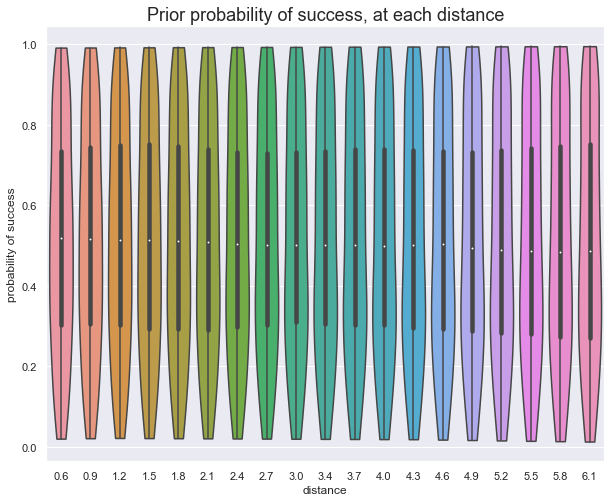

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
prior_probs = pd.DataFrame(prior_samples['probs'])
prior_probs = pd.melt(prior_probs, var_name='distance', value_name='probability of success')
prior_probs['distance'] = prior_probs['distance'].map(df['distance'])
prior_probs
sns.violinplot(data=prior_probs, x='distance', y='probability of success', ax=ax, cut=0);
ax.set_title('Prior probability of success, at each distance', fontdict={'fontsize': 18});

## Now, the priors look a lot flatter!

Lesson learned: flat priors in the parameter scale are not the same as flat priors in the outcome scale.

## Right, let's try fitting the model, and visualising the posterior!

In [12]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    distance=df['distance'].to_numpy(),
    tries=df['tries'].to_numpy(),
    successes=df['successes'].to_numpy(),
)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      2.12      0.06      2.12      2.02      2.20   1144.91      1.00
         β     -0.79      0.02     -0.79     -0.83     -0.76   1191.81      1.00

Number of divergences: 0


In [13]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    distance=df['distance'].to_numpy(),
    tries=df['tries'].to_numpy(),
)

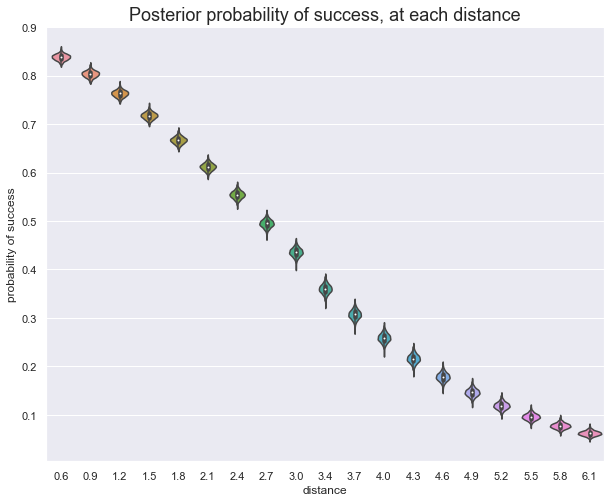

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
post_probs = pd.DataFrame(post_samples['probs'])
post_probs = pd.melt(post_probs, var_name='distance', value_name='probability of success')
post_probs['distance'] = post_probs['distance'].map(df['distance'])
sns.violinplot(data=post_probs, x='distance', y='probability of success', ax=ax, cut=0);
ax.set_title('Posterior probability of success, at each distance', fontdict={'fontsize': 18});

## Cool! Let's see how well it fits the training data

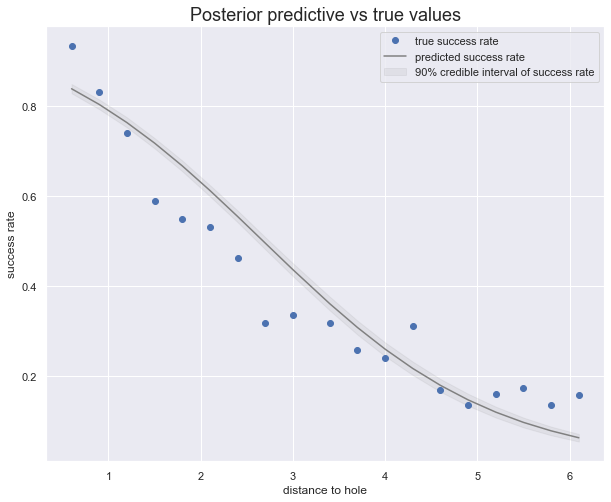

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df['distance'], df['success_rate'], 'o', label='true success rate');
ax.fill_between(df['distance'], *numpyro.diagnostics.hpdi(post_samples['probs']), color='grey', alpha=.1, label='90% credible interval of success rate');
ax.plot(df['distance'], post_samples['probs'].mean(axis=0), color='grey', label='predicted success rate');
ax.set_xlabel('distance to hole')
ax.set_ylabel('success rate')
ax.legend();
ax.set_title('Posterior predictive vs true values', fontdict={'fontsize': 18});

Not bad. Bit high in the middle, and low at highest distances.

## But maybe...distance isn't the most influential factor?

> The size of an official golf ball can be no smaller than (1.68 inches) in diameter. This equals to (4.268 cm) or (42.68 mm)

> Golf holes all over the world today measure 4¼ inches (even in metric countries, where that is approximately 10.8 centimetres), and they have been this size since 1891.

In [16]:
ball_radius = .04268/2
hole_radius = .108/2

In [17]:
df['angle'] = np.arcsin((hole_radius-ball_radius)/df['distance'])

In [18]:
df

,distance,tries,successes,success_rate,angle
0,0.6,1443,1346,0.932779,0.108921
1,0.9,694,577,0.831412,0.072594
2,1.2,455,337,0.740659,0.054440
3,1.5,353,208,0.589235,0.043550
4,1.8,272,149,0.547794,0.036291
5,2.1,256,136,0.531250,0.031106
6,2.4,240,111,0.462500,0.027218
7,2.7,217,69,0.317972,0.024193
8,3.0,200,67,0.335000,0.021774
9,3.4,237,75,0.316456,0.019212


## Maybe, we can  make a model using just the radians? Let's see

In [34]:
def model(angle, tries, successes=None):
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.Normal(0, .5),
    )
    
    probs = numpyro.deterministic('probs', 2*jax.scipy.stats.norm.cdf(angle, loc=0, scale=sigma)-1)
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(tries, probs),
        obs=successes,
    )

In [35]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    angle=df['angle'].to_numpy(),
    tries=df['tries'].to_numpy(),
)

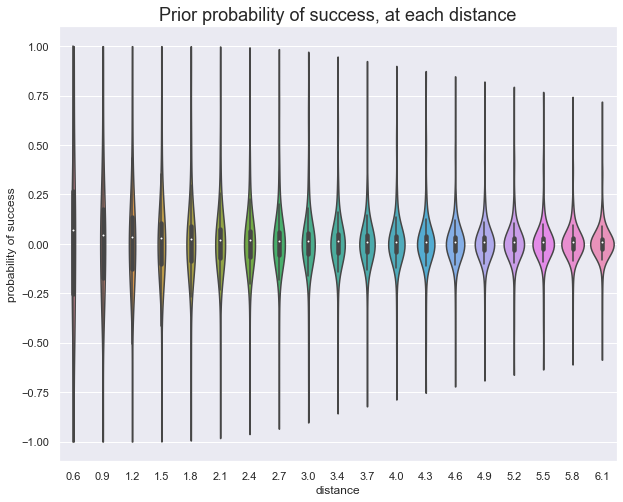

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
prior_probs = pd.DataFrame(prior_samples['probs'])
prior_probs = pd.melt(prior_probs, var_name='distance', value_name='probability of success')
prior_probs['distance'] = prior_probs['distance'].map(df['distance'])
prior_probs
sns.violinplot(data=prior_probs, x='distance', y='probability of success', ax=ax, cut=0);
ax.set_title('Prior probability of success, at each distance', fontdict={'fontsize': 18});

## Right, let's try fitting the model, and visualising the posterior!

In [37]:
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(0),
    angle=df['angle'].to_numpy(),
    tries=df['tries'].to_numpy(),
    successes=df['successes'].to_numpy(),
)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.05      0.00      0.05      0.05      0.06   1408.78      1.00

Number of divergences: 0


In [38]:
post_pred = numpyro.infer.Predictive(model, mcmc.get_samples())
post_samples = post_pred(
    jax.random.PRNGKey(0),
    angle=df['angle'].to_numpy(),
    tries=df['tries'].to_numpy(),
)

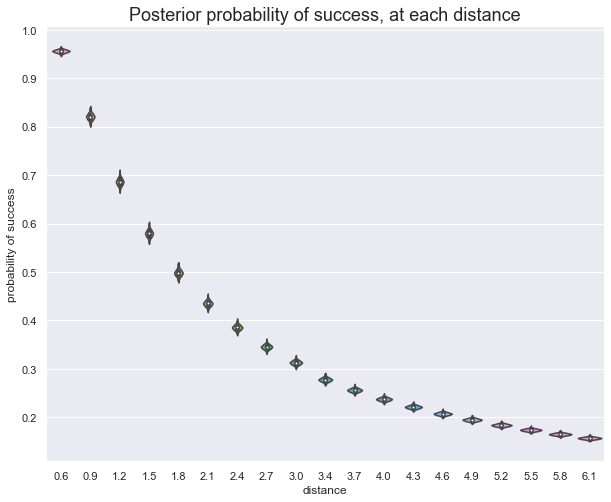

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
post_probs = pd.DataFrame(post_samples['probs'])
post_probs = pd.melt(post_probs, var_name='distance', value_name='probability of success')
post_probs['distance'] = post_probs['distance'].map(df['distance'])
sns.violinplot(data=post_probs, x='distance', y='probability of success', ax=ax, cut=0);
ax.set_title('Posterior probability of success, at each distance', fontdict={'fontsize': 18});

## Cool! Let's see how well it fits the training data

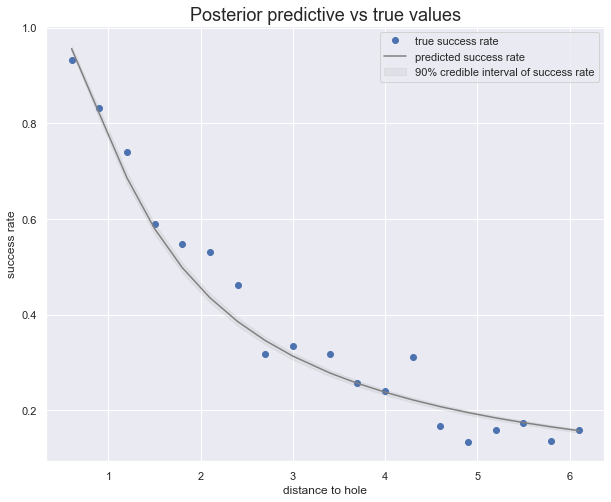

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df['distance'], df['success_rate'], 'o', label='true success rate');
ax.fill_between(df['distance'], *numpyro.diagnostics.hpdi(post_samples['probs']), color='grey', alpha=.1, label='90% credible interval of success rate');
ax.plot(df['distance'], post_samples['probs'].mean(axis=0), color='grey', label='predicted success rate');
ax.set_xlabel('distance to hole')
ax.set_ylabel('success rate')
ax.legend();
ax.set_title('Posterior predictive vs true values', fontdict={'fontsize': 18});

In [41]:
prior_probs

,distance,probability of success
0,0.6,-0.483223
1,0.6,0.104030
2,0.6,0.191614
3,0.6,0.204865
4,0.6,-0.554570
...,...,...
1895,6.1,-0.061863
1896,6.1,0.367356
1897,6.1,-0.258175
1898,6.1,-0.020973
